In [ ]:
import numpy as np
import random
import scipy
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.special import softmax

#Loopy belief propagation 

Loopy belief propagation is adapted to sample from the marginals given $(y_{1},.....y_{n})$. In fact the structure of our graph is not a tree so we can not apply the sum product algorithm on it. Furthermore, the junction tree algorithm has a large running time since we must concatenate many variables to form a tree structure. Therefore, using loopy belief propagation for inference is a good option, even though it is not an exact algorithm. \\
The idea is to pick randomly at each iteration a root from the graph, then to propagate the messages from the leaves to the root with respect to the rule that each node $x_{i}$ delivers its message to a node $x_{j}$ once it has received the messages from its neighbours excluding $x_{i}$. \\
For the Ising model, I chose the directions of messages propagation to be as left , right , up , down. We randomly select the order of the directions at each iteration.  
The algorithm is then : 
* Initialize all the messages $\mu_{i,j \rightarrow l,k} $ with 1.
* For iteration t : 
  * For direction $i$ in {left,right,up,down} ( we change the order at each   iteration) :
    * Considering the propagation from left to right (all other directions can be done by symmetry), update the messages as follows :
    $$\mu_{i,j \rightarrow i,j+1}(x_{i,j+1})=\sum_{x_{i,j}=0}^{1}\psi(x_{i,j})\psi(x_{i,j},x_{i,j+1}) p(y_{i,j}|x_{i,j}) \prod_{v \in Neigh(x_{i,j}) \setminus x_{i,j+1}} \mu_{v \rightarrow x_{i,j}}(x_{i,j})$$

Where : 
$$ \left\{
        \begin{array}{ll}
            \psi(x_{i,j}) = \exp(\alpha x_{i,j}) \\
            \psi(x_{i,j},x_{i,j+1}) = \exp( \beta \times \mathbb{1} (x_{i,j}=x_{i,j+1})) \end{array} 
            \right.
$$
Here v represents the nodes under, above and to the left of $x_{i,j}$ supposing it's not an edge node. 
Moreover , we will use the logsumexp trick to avoid numerical instabilities. 
Once the messages update algorithm has converged, The next step is to calculate the marginals of $x_{i}$ given the observations : 
$$p(x_{i,j}|y_{1,1}....y_{n,n}) \propto \psi(x_{i,j}) p(y_{i,j}|x_{i,j}) \prod_{v \in Neigh(x_{i,j})} \mu_{v \rightarrow x_{i,j}}(x_{i,j}) $$. 
Concretely : 
$$p(x_{i,j}=1|y_{1,1}....y_{n,n}) \sim \mathcal{B}(\frac{\exp(\tilde{p}(x_{i,j}=1|y_{1,1}....y_{n,n}))}{\exp(\tilde{p}(x_{i,j}=1|y_{1,1}....y_{n,n}))+\exp(\tilde{p}(x_{i,j}=0|y_{1,1}....y_{n,n}))}) $$
Where $\tilde{p}$ is the unnormalized probability defined just above.
For practical reasons , I will take the argmax of the unnormalized probability to sample from the marginal. This is due to overflow problems when passing to exponentials. 

In [ ]:
class LoopyBelief() : 
  """
  Class for loppy belief propagation. The messages propagation is done in the method fit. 
  
  Attributes : 
  alpha_ : paramter alpha of the joint.
  beta_ : paramter beta of the joint.
  mu0_ : mean of the gaussian given x=0.
  mu1_ : mean of the gaussian given x=1.
  scaling_factor_ : the scale to downsample the original image.
  height_ : height of the original image.
  width_ : width of the original image.
  belief : final belief for the denoised image.
  path : path to image. 
  sigma_ : standard deviation for the posterior gaussians.
  img_array : original image.
  observations : noised image.
  """
    def __init__(self, path = "spiral.png",n_iter = 10 , alpha = 0. , 
                 beta = 1 ,mu0 = 0.2 ,mu1 =0.8 ,sigma = 0.5,scaling_factor = 10  ):
      self.alpha_ = alpha
      self.beta_  = beta
      self.mu0_ = mu0 
      self.mu1_ = mu1
      self.scaling_factor_ = scaling_factor
      self.n_iter_ = n_iter
      self.height_ = None
      self.width_ = None
      self.belief = None
      self.path_ = path
      self.sigma_ = sigma
      self.img_array = None
      self.observations = self.generate_obser()
    def generate_obser (self) : 
      
      im = Image.open(self.path_)
      (self.width_, self.height_) = (im.width //self.scaling_factor_, im.height // self.scaling_factor_)
      print('width is {} and height is {}'.format(self.width_,self.height_))
      im = im.resize(size = (self.width_, self.height_) , resample=Image.NEAREST)
      img_array = np.array(im)
       
      self.img_array = img_array[:,:,0]/255
      
      plt.imshow(self.img_array,cmap='gray')
      plt.title('Original image')
      plt.show()
      observations = np.zeros((self.height_,self.width_))
      for n in range(self.height_):
        for p in range(self.width_) :
          if self.img_array[n,p]==0. : 
            observations [n,p] = np.random.normal(self.mu0_, self.sigma_, 1)
          else:
            observations [n,p] = np.random.normal(self.mu1_,self.sigma_, 1)
      plt.imshow(observations,cmap='gray')
      plt.title('noisy image')
      plt.show()
      return observations

    def init_messages(self):
      """
      Init the messages in all directions by zero ( log term )
      """
      self.messages = np.zeros((self.height_,self.width_,4,2))

    def determine_neighbours(self,n,p,direction,belief=False) :
      dict_neighbours ={}
      for dir in range(4) : 
          if belief == False : 
            if dir == direction : 
              continue
          if dir == 0 :
            if p > 0 :
              dict_neighbours[dir] = (n,p-1)
          if dir == 1 : 
            if p < self.width_ - 1 : 
              dict_neighbours[dir] = (n,p+1)
          elif dir == 2 : 
            if n > 0 : 
              dict_neighbours[dir] = (n-1,p)
          elif dir == 3 :
            if n< self.height_ - 1 :
              dict_neighbours[dir] = (n+1,p)
      return dict_neighbours
            
    def compute_posterior_term(self,n,p,l_prime) :
      observ = self.observations[n,p]
      if l_prime ==0 :
        return np.log(scipy.stats.norm(self.mu0_, self.sigma_).pdf(observ))# + 0.5 * np.log(2 * np.pi)
      return np.log(scipy.stats.norm(self.mu1_, self.sigma_).pdf(observ))#+ 0.5 * np.log(2 * np.pi)

    def compute_joint_term(self,l,l_prime):
      return self.alpha_ * l_prime + self.beta_ * int(l==l_prime)

    def update_single_message(self ,n,p,l , direction, set_neighbours) :
      binary_update = []
      for l_prime in range(2) :
        posterior_term = self.compute_posterior_term(n,p,l_prime)
        joint_term = self.compute_joint_term(l,l_prime)
        messages_term = 0
        for neigh_dir,value in set_neighbours.items() :
            neigh_n , neigh_p = value[0],value[1]
            
            messages_term += self.messages[neigh_n,neigh_p,neigh_dir,l_prime]
        message_update = posterior_term + joint_term + messages_term
        """
        print('data cost',data_cost)
        print('smoothness cost',smoothness_cost)
        print('messages term',messages_term)
        """
        binary_update.append(message_update)
      max_term = np.max(np.array(binary_update))
      ## log-sum-exp trick
      self.messages[n,p,direction,l] = max_term + np.log(np.sum(np.exp(np.array(binary_update)-max_term)))

    def update_message(self,direction) :
      """
      update messages in a given direction
      """
      for n in range(self.height_) :
        for p in range(self.width_):
          set_neighbours = self.determine_neighbours(n,p,direction)
          for l in range(2) : 
            self.update_single_message(n = n ,p = p ,l = l , direction = direction, set_neighbours =set_neighbours )

    def fit (self):
      """
      Function that updates the messages with the scheme right left up down at different orders . 
      """
      self.init_messages()
      l=[0,1,2,3]
      for iter in tqdm(range(self.n_iter_),total = self.n_iter_) :
        random.shuffle(l)
        for k in l : 
          self.update_message(k)

        print('Iter {}'.format(iter+1))
        self.sample_image()

    def sample_image(self) : 
      self.set_beliefs()
      plt.imshow(self.belief,cmap='gray')
      plt.show()

    def set_beliefs(self) : 
      """
      Calculate beliefs. 
      """
      self.belief = np.zeros((self.height_,self.width_))
      for n in range(self.height_) :
        for p in range(self.width_):
          set_neighbours = self.determine_neighbours(n,p,direction=None,belief=True)
          binary_beliefs = []
          for l in range(2):
              posterior_term = self.compute_posterior_term(n,p,l)
              psi_term = self.alpha_ * l 
              messages_term = 0
              for key,value in set_neighbours.items() :
                  neigh_n , neigh_p = value[0],value[1]
                  messages_term += self.messages[neigh_n,neigh_p,key,l]
              binary_beliefs.append(posterior_term +psi_term+ messages_term)
          
          self.belief[n,p] = np.argmax(np.array(binary_beliefs))



width is 140 and height is 80


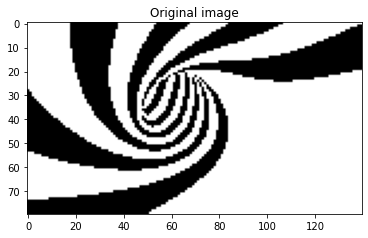

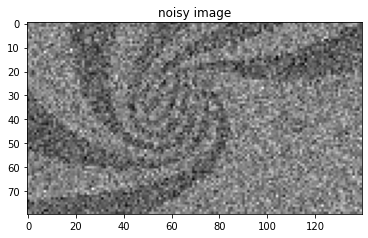

Iter 1


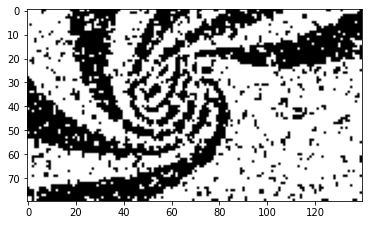

Iter 2


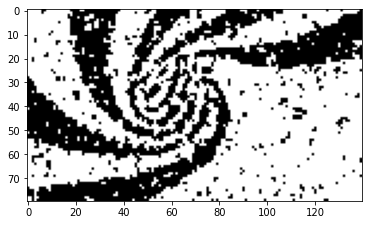

Iter 3


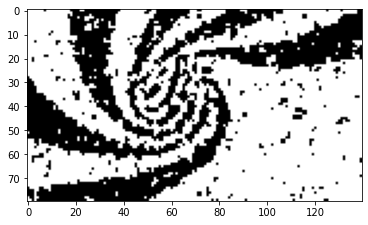

In [ ]:
ising = ISING(n_iter=3 , scaling_factor=5 ,sigma = 0.5 , alpha =0.05 , beta = 0.8)
ising.fit()

## Results
The algorithm converged after three iterations. The denoised image is still a little bit noisy but we recover the major part of the input.

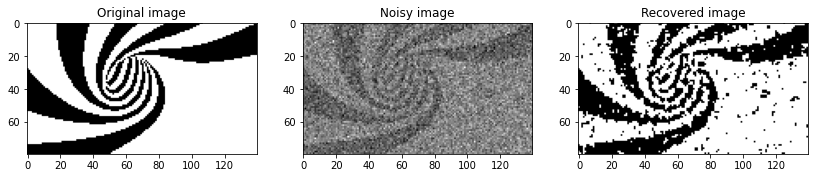

In [ ]:
fig,axis = plt.subplots(1,3,figsize=(14,10))

axis[0].imshow(ising.img_array,cmap='gray')
axis[0].set_title('Original image')


axis[1].imshow(ising.observations,cmap='gray')
axis[1].set_title('Noisy image')


axis[2].imshow(ising.belief,cmap='gray')
axis[2].set_title('Recovered image')

plt.show()

# MCMC 

In order to sample from the distribution $p(x_{i}|Y)$ where $Y=(y_{1},y_{2},.....,y_{n})$, we will use MCMC with gibbs sampling. The steps of this algorithm are as follows : 
* Initialize the matrix $X$ of the image by the observed noised image Y with a threshold to obtain binary pixels. So $X = int(Y>0.5)$
* At step t :
  * for $i$ in $1....N$ : 
    * Sample $\tilde{x_{i}} \sim p(x_{i}|x_{-i},Y)$
    * $X = (x_{1},..,\tilde{x_{i}},...,x_{n})$
  * $X^{(t)} = X$

To sample from $p(x_{i}|x_{-i},Y)$, we should use the structure of the ISING model graph. Thus we have : 
\begin{align}
p(x_{i}|x_{-i},Y) &= p(x_{i}|x_{neigh},y_{i})\; \text{ , where } x_{neigh} \text{ are the neighbour pixels of } x_{i} \\
&\propto p(x_{i},x_{neigh},y_{i}) \\
&\propto p(y_{i}|x_{i},x_{neigh}) p(x_{i},x_{neigh}) \\
&\propto p(y_{i}|x_{i}) p(x_{i}|x_{neigh}) 
\end{align}
The last line can be explained by the fact that observing $x_{i}$ blocks $x_{neigh}$ when we compute $ p(y_{i}|x_{i},x_{neigh}). $
Replacing the above terms by their expressions we get : 
$$p(x_{i}|x_{-i},Y) \propto f(y_{i}; \mu_{i},\sigma) \exp(\alpha x_{i}+ \beta \sum_{x_{neigh}} \mathbb{1}(x_{neigh}=x_{i}) )$$
Where $f(y_{i}; \mu_{i},\sigma)$ is the gaussian density function taken at $y_{i}$, with mean $\mu_{i}$ and standard deviation $\sigma$. The last step is to normalize the above probabilty which is simple since $x_{i} \in \left\{0,1\right\}$ so we have to add only two terms. 

In [ ]:
class MCMC() : 
    """
    Class for MCMC method. The marginal law update is done in the method fit. 
    
    Attributes : 
    alpha_ : paramter alpha of the joint.
    beta_ : paramter beta of the joint.
    mu0_ : mean of the gaussian given x=0.
    mu1_ : mean of the gaussian given x=1.
    scaling_factor_ : the scale to downsample the original image.
    height_ : height of the original image.
    width_ : width of the original image.
    belief : final belief for the denoised image.
    path : path to image. 
    sigma_ : standard deviation for the posterior gaussians.
    img_array : original image.
    observations : noised image.
    n_iter : iterations of gibbs sampling.
    EM : whether we are using gibbs for EM framework ( to sample a latent 
    variable from the posterior law in the E step) or not. One difference is
    that we don't plot the updated samples in EM.
    """
    def __init__(self, path = "spiral.png",n_iter = 10 , alpha = 0.05 , 
                 beta = 1 ,mu0 = 0.2 ,mu1 =0.8 ,sigma = 0.5,scaling_factor = 10, EM = False ):
      self.alpha_ = alpha
      self.beta_  = beta
      self.mu0_ = mu0 
      self.mu1_ = mu1
      self.scaling_factor_ = scaling_factor
      self.n_iter_ = n_iter
      self.height_ = None
      self.width_ = None
      self.path_ = path
      self.img_array = None
      self.sigma_ = sigma
      self.probs_ = None
      self.EM_ = EM
      self.samples_ = None
      if EM == False : 
        self.observations = self.generate_obser()
      else : 
        self.observations = None
      
    def generate_obser (self) : 
      
      im = Image.open(self.path_)
      (self.width_, self.height_) = (im.width //self.scaling_factor_, im.height // self.scaling_factor_)
      print('width is {} and height is {}'.format(self.width_,self.height_))
      im = im.resize(size = (self.width_, self.height_) , resample=Image.NEAREST)
      img_array = np.array(im)
       
      self.img_array = img_array[:,:,0]/255
      
      plt.imshow(self.img_array,cmap='gray')
      plt.title('Original image')
      plt.show()
      observations = np.zeros((self.height_,self.width_))
      for n in range(self.height_):
        for p in range(self.width_) :
          if self.img_array[n,p]==0. : 
            observations [n,p] = np.random.normal(self.mu0_, self.sigma_, 1)
          else:
            observations [n,p] = np.random.normal(self.mu1_,self.sigma_, 1)
      plt.imshow(observations,cmap='gray')
      plt.title('noisy image')
      plt.show()
      return observations

    def init_probs(self):
      """
      Init the messages in all directions by zero
      """
      self.samples_ = (self.observations>0.5).astype(np.int)

    def determine_neighbours(self,n,p) :
      dict_neighbours ={}
      for dir in range(4) : 
          if dir == 0 :
            if p > 0 :
              dict_neighbours[dir] = (n,p-1)
          if dir == 1 : 
            if p < self.width_ - 1 : 
              dict_neighbours[dir] = (n,p+1)
          elif dir == 2 : 
            if n > 0 : 
              dict_neighbours[dir] = (n-1,p)
          elif dir == 3 :
            if n< self.height_ - 1 :
              dict_neighbours[dir] = (n+1,p)
      return dict_neighbours
            
    def get_joint_prob(self,n,p,l,set_neighbours) :
      joint_prob = self.alpha_ * l 
      for key,value in set_neighbours.items():
        n_neigh,p_neigh = value[0],value[1]
        neigh_sample = self.samples_[n_neigh,p_neigh]
        joint_prob += self.beta_ * int(l==neigh_sample)
      return np.exp(joint_prob)
      
      
    def get_obsv_prob(self, n,p,l) : 
      observ = self.observations[n,p]
      if l ==0 :
        return scipy.stats.norm(self.mu0_, self.sigma_).pdf(observ)
      return scipy.stats.norm(self.mu1_, self.sigma_).pdf(observ)


    def update_sample(self,n,p) :
      """
      Update a single xi given yi and its neighbours.
      """
      set_neighbours = self.determine_neighbours(n,p)
      probs = []
      for l in range(2): 
        y_prob = self.get_obsv_prob(n,p,l)
        joint_prob = self.get_joint_prob(n,p,l,set_neighbours)
        probs.append(y_prob*joint_prob)

      prob = probs[1]/(probs[0]+probs[1])
      self.samples_[n,p] = np.random.binomial(size=1, n=1, p= prob)[0]



          

    def fit (self):
      """
      Function that updates the joint law distribution by gibbs sampling. 
      """
      self.init_probs()
      if self.EM_ == False : 
        self.sample_image(iter = 0 )
      for iter in tqdm(range(self.n_iter_),total = self.n_iter_) :
        for n in range(self.height_) :
          for p in range(self.width_):
            self.update_sample(n,p)
        
        if self.EM_ == False : 
          self.sample_image(iter = iter+1)

    def sample_image(self,iter) : 
      plt.imshow(self.samples_,cmap='gray')
      plt.title('Iteration {} of gibbs sampling'.format(iter))
      plt.show()


width is 140 and height is 80


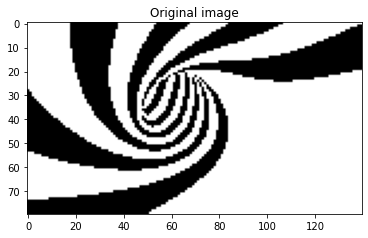

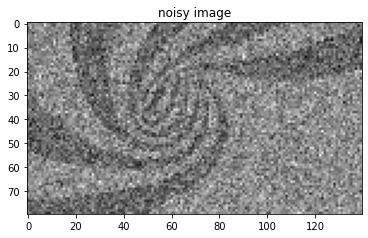

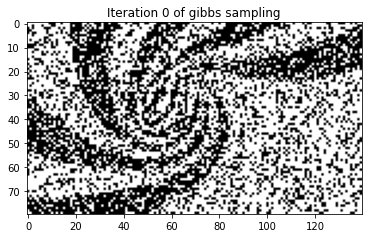

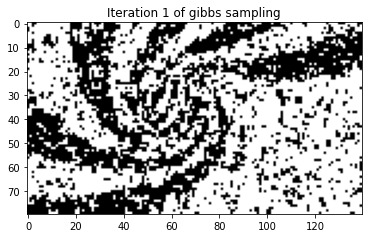

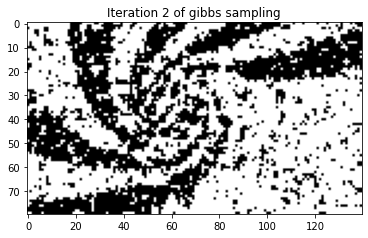

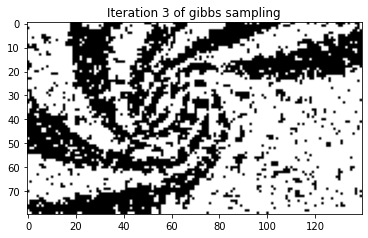

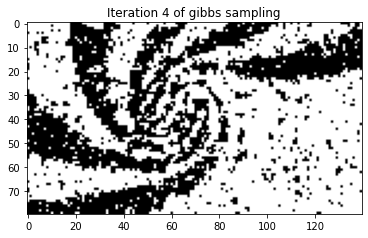

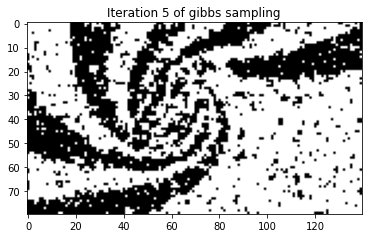

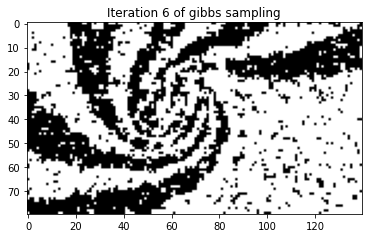

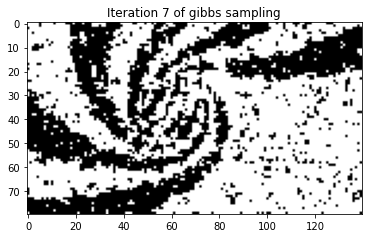

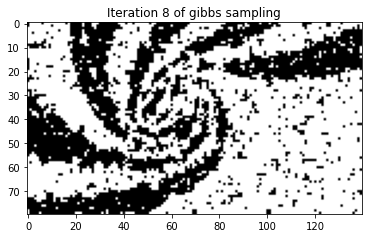

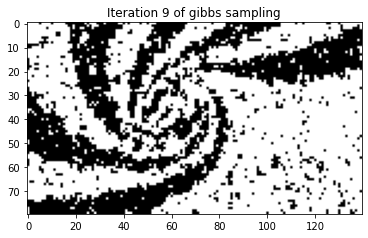

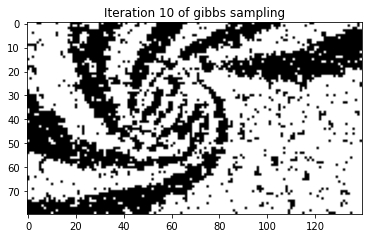

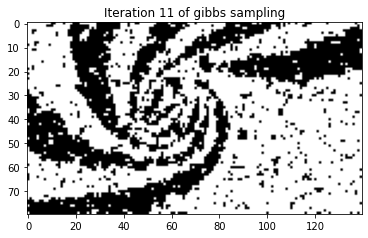

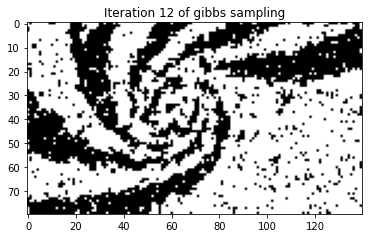

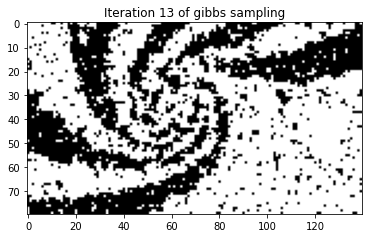

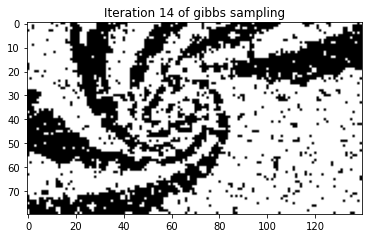

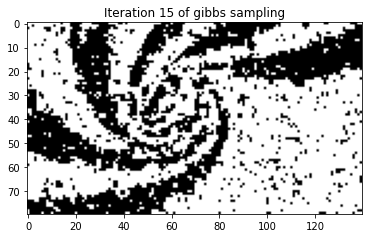

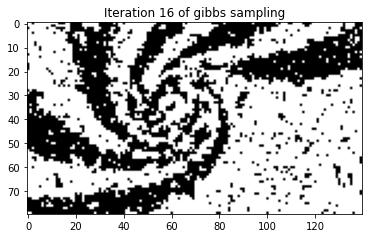

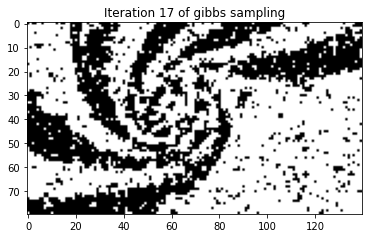

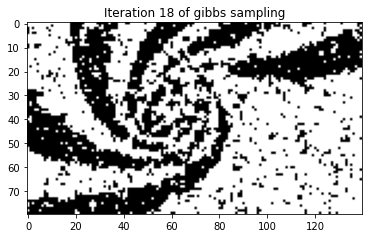

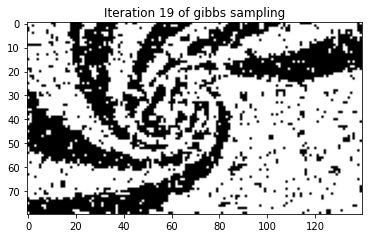

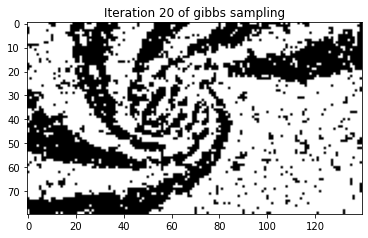

In [ ]:
mcmc = MCMC(n_iter=20 , scaling_factor=5 ,sigma = 0.5 , alpha =0.05 , beta = 0.8)
mcmc.fit()

## Results

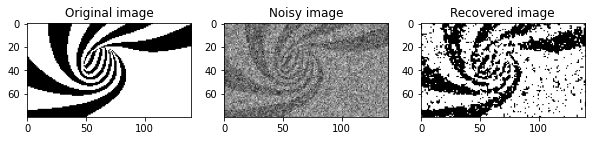

In [ ]:
fig,axis = plt.subplots(1,3,figsize=(10,6))

axis[0].imshow(mcmc.img_array,cmap='gray')
axis[0].set_title('Original image')


axis[1].imshow(mcmc.observations,cmap='gray')
axis[1].set_title('Noisy image')


axis[2].imshow(mcmc.samples_,cmap='gray')
axis[2].set_title('Recovered image')

plt.show()

We can see that the recovered image by MCMC is less relevant than the one recovered by loopy belief propagation. One possible explanation is that we are still in the burn-in step after 20 iterations, so we didn't attain yet the stationnary distribution. Also we may don't have the optimal values of $\alpha$ and $\beta$ which motivates the next parts. Nevertheless, MCMC with gibbs sampling is faster than loopy belief propagation. We also have the guarantee that the algorithm converges which is not the case for the loopy belief propagation method. 

# EM algorithm

Let's set $\theta = (\mu_{0},\mu_{1})$ . We will use The EM algorithm to maximize the log-likelihood $P(y_{1},....,y_{n} |\theta)$. In this case the EM algorithm consists of : \\
* At step 0 , initialize the parameters $\theta$.

At step t+1 , compute the corresponding expectation and maximization steps: 
* E-step : compute $p(X|Y,\theta^{(t)})$. But since we don't have a closed form for this probabilty, we will take m samples from it to use in the M-step. In order to have relevant samples, we will run the gibbs sampling defined earlier for k steps given $\theta^{(t)}$.
* M-step : compute $\theta^{(t+1)}$ defined by :
$$\theta^{(t+1)} = \underset{\theta}{\mathrm{argmax}} \; \sum_{X \sim p(X|Y,\theta^{(t)})}  \ln p(X,Y,\theta)$$
We will start by taking only one sample of the hidden variables $X$. So we can rewrite the M-step as : 
\begin{align}
\theta^{(t+1)} &= \underset{\theta}{\mathrm{argmax}} \; \ln p(X,Y,\theta) \; \; \text{, where } X \sim p(X|Y,\theta^{(t)}). \\
&= \underset{\theta}{\mathrm{argmax}} \; \ln p(Y|X,\theta) \; \; \text{, because } P(X) \; \text{does not depend on } \theta. \\
&= \underset{\theta}{\mathrm{argmax}} \; \sum_{i=1}^{N} \ln p(y_{i}|x_{i},\theta)\\
&= \underset{\mu_{0},\mu_{1}}{\mathrm{argmax}} \; \sum_{i=1}^{N} x_{i} \ln f(y_{i};\mu_{1},\sigma)+ (1-x_{i}) \ln f(y_{i};\mu_{0},\sigma) \; \; \text{where } f\text{ is the density function of a normal distribution.}
\end{align}
After removing the constant terms, we have : 
$$\theta^{(t+1)} = \underset{\mu_{0},\mu_{1}}{\mathrm{argmax}} \; \sum_{i=1}^{N} - x_{i} (y_{i}-\mu_{1})^{2} - (1-x_{i}) (y_{i}-\mu_{0})^{2} $$
We then set the gradient of the term above to zero. We easily find : 
$$
\left\{
    \begin{array}{ll}
        \mu_{1}^{(t+1)} = \frac{\sum_{i=1}^{N} x_{i}y_{i}}{\sum_{i=1}^{N} x_{i}} \\
        \mu_{0}^{(t+1)}= \frac{\sum_{i=1}^{N} (1-x_{i})y_{i}}{\sum_{i=1}^{N} 1-x_{i}}
    \end{array}
\right.
$$

In [ ]:
class EMAlgorithm():
    def __init__(self, path = "spiral.png", max_iter = 100 , alpha = 0.05 , 
                 beta = 1 ,true_mu0 = 0.2 ,true_mu1 =0.8 ,sigma = 0.5,scaling_factor = 10,eps = 1e-3  ):
      self.alpha_ = alpha
      self.beta_  = beta
      self.true_mu0_ = true_mu0
      self.true_mu1_ = true_mu1
      self.mu0_,self.mu1_= self.init_mu()
      self.scaling_factor_ = scaling_factor
      self.max_iter_ = max_iter
      self.height_ = None
      self.width_ = None
      self.path_ = path
      self.sigma_ = sigma
      self.eps_ = eps
      self.observations = self.generate_obser()
    def init_mu(self) : 
      return random.random(),random.random()
    def generate_obser (self) : 
      
      im = Image.open(self.path_)
      (self.width_, self.height_) = (im.width //self.scaling_factor_, im.height // self.scaling_factor_)
      print('width is {} and height is {}'.format(self.width_,self.height_))
      im = im.resize(size = (self.width_, self.height_) , resample=Image.NEAREST)
      img_array = np.array(im)
       
      img_array = img_array[:,:,0]/255
      
      plt.imshow(img_array,cmap='gray')
      plt.title('Original image')
      plt.show()
      observations = np.zeros((self.height_,self.width_))
      for n in range(self.height_):
        for p in range(self.width_) :
          if img_array[n,p]==0. : 
            observations [n,p] = np.random.normal(self.true_mu0_, self.sigma_, 1)
          else:
            observations [n,p] = np.random.normal(self.true_mu1_,self.sigma_, 1)
      plt.imshow(observations,cmap='gray')
      plt.title('noisy image')
      plt.show()
      return observations
    def calculate_joint_distr(self,x,y) :
      return - np.sum(x*(y-self.mu1_)**2 + (1-x) *(y-self.mu0_)**2)

    def fit(self,n_gibbs = 5) : 
      """
      Fit EM algorithm.
      """
      joint_distr_new, joint_distr_old= np.inf , 0
      iter = 0
      print('Initial mu 0 is :',self.mu0_)
      print('Initial mu 1 is :',self.mu1_)
      while (iter< self.max_iter_) and (np.abs(joint_distr_new -joint_distr_old ))> self.eps_ : 
          joint_distr_old = joint_distr_new
          ## E step : we use gibbs sampling ta draw an example from the posterior.
          mcmc = MCMC(n_iter=n_gibbs , sigma = self.sigma_ , alpha =self.alpha_, 
                      beta = self.beta_ , mu0 = self.mu0_ , mu1 = self.mu1_ , 
                      EM=True )
          mcmc.height_ = self.height_
          mcmc.width_  = self.width_
          mcmc.observations = self.observations
          mcmc.fit()
          mcmc.sample_image(iter = iter+1)
          X_sample = mcmc.samples_

          ## M step :
          self.mu1_ = np.sum(X_sample*self.observations) / np.sum(X_sample)
          self.mu0_ = np.sum((1-X_sample)*self.observations) / np.sum((1-X_sample))

          joint_distr_new = self.calculate_joint_distr(X_sample,self.observations)
          print('Lower bound term for iteration {} is {}'.format(iter+1,joint_distr_new))
          print('mu 0 is :',self.mu0_)
          print('mu 1 is :',self.mu1_)
          iter+=1





width is 140 and height is 80


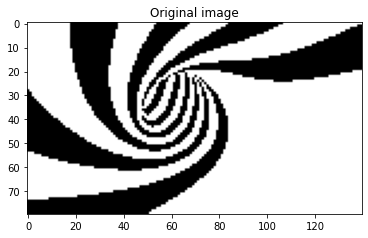

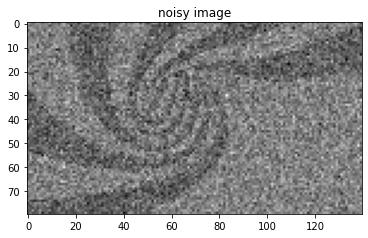

Initial mu 0 is : 0.9959088169661441
Initial mu 1 is : 0.9705300398133061


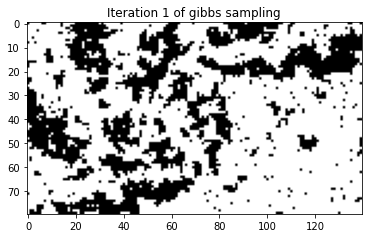

Lower bound term for iteration 1 is -3486.030228755084
mu 0 is : 0.374311105428251
mu 1 is : 0.6760940823439732


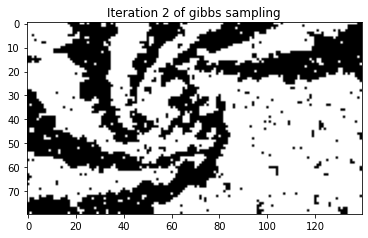

Lower bound term for iteration 2 is -2957.152457634129
mu 0 is : 0.23501236830639016
mu 1 is : 0.7746182141839514


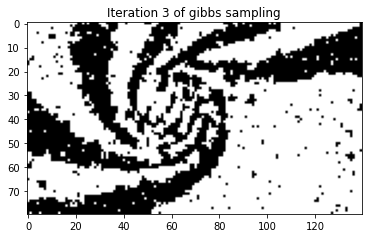

Lower bound term for iteration 3 is -2729.3536621209805
mu 0 is : 0.18821050920928856
mu 1 is : 0.8034566611597403


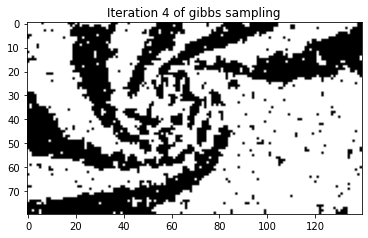

Lower bound term for iteration 4 is -2695.534130067459
mu 0 is : 0.16905251093418697
mu 1 is : 0.8005898489187336


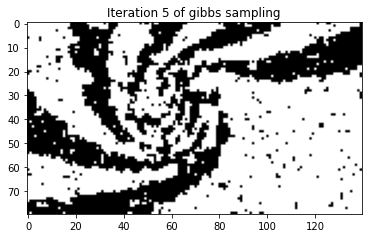

Lower bound term for iteration 5 is -2684.5193667125363
mu 0 is : 0.16396769107419057
mu 1 is : 0.8003064518413175


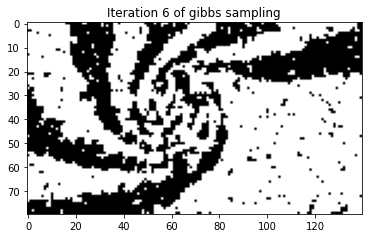

Lower bound term for iteration 6 is -2692.0744869100868
mu 0 is : 0.16981725297033756
mu 1 is : 0.8017365674137688


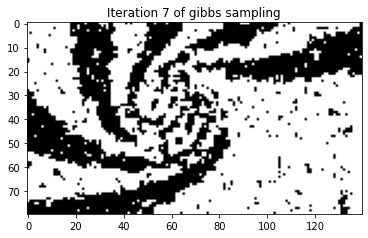

Lower bound term for iteration 7 is -2672.6776491759056
mu 0 is : 0.171982974176461
mu 1 is : 0.8070884454740198


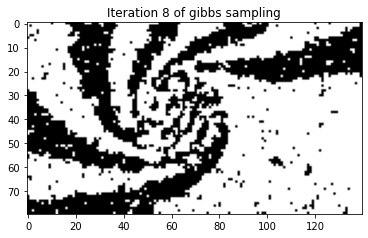

Lower bound term for iteration 8 is -2647.9800954414122
mu 0 is : 0.16271384080820062
mu 1 is : 0.8074097022282126


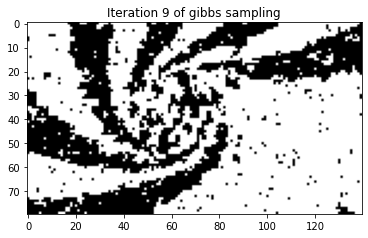

Lower bound term for iteration 9 is -2658.5448760176187
mu 0 is : 0.16283925401565294
mu 1 is : 0.8052354385590407


KeyboardInterrupt: ignored

In [ ]:
em = EMAlgorithm(sigma = 0.5 , scaling_factor = 5 )
em.fit(n_gibbs = 5)

In few iterations, the EM algorithm converged to the true values of $\mu_{0}$ and $\mu_{1}$, even though I used stochastic EM algorithm and not the exact one, and the starting values of the parameters are far from the true ones(0.2 and 0.8). Nevertheless, we can see the effect of noise caused by the sample of a single $x$ as the value $\mu_{0}$ is still oscillating after eight iterations. Another important remark is that we didn't need many steps of gibbs sampling to approximate the posterior law. 

#Question 4

If we assume that $\alpha$ and $\beta$ are unknown, we have in the M-step:
\begin{align}
\theta^{(t+1)} &= \underset{\theta}{\mathrm{argmax}} \; \ln p(X,Y,\theta) \; \; \text{, where } X \sim p(X|Y,\theta^{(t)}). \\
&= \underset{\mu_{0},\mu_{1},\alpha,\beta}{\mathrm{argmax}} \; \ln p(Y|X,\mu_{0},\mu_{1}) + \ln p(X;\alpha,\beta) \\
\end{align}
This time, we don't cancel the term of the joint distribution since we want to maximize also with respect to $\alpha$ and $\beta$.
The problem with the maximization above is that it involves computing the partition function Z that depends on $\alpha$ and $\beta$, but this computation is intractable since it involves summing over all the possible $x_{i}$ terms.  

#Question 5

Given the prior distribution for the parameters $(\alpha, \beta, \mu_0, \mu_1)$, we want to sample from this distribution $p(\alpha, \beta, \mu_0, \mu_1,x|y)$. We have:
$$
p(\alpha, \beta, \mu_0, \mu_1,x|y) \propto p(x | \alpha, \beta, \mu_0, \mu_1,y).p(\alpha, \beta, \mu_0, \mu_1|x,y)
$$
Sampling from $x$ given the parameters $(\alpha, \beta, \mu_0, \mu_1)$ and the data $y$ can be done using the same method as in question 2 using MCMC with Gibbs sampling. \\
We will try now to sample from $p(\alpha, \beta, \mu_0, \mu_1|x,y)$. \\
We have:
\begin{align}
p(\alpha, \beta, \mu_0, \mu_1|y) &= \frac{p(y|\alpha, \beta, \mu_0, \mu_1).p(\alpha, \beta, \mu_0, \mu_1|x)}{p(y)} \\
&\propto p(y|\alpha, \beta, \mu_0, \mu_1).p(\alpha, \beta, \mu_0, \mu_1|x)
\end{align}

Moreover
$$
p(y|\alpha, \beta, \mu_0, \mu_1) \propto \prod_{i=1}^{n} \sum_{k \in \{0,1\}} p(y_i,x_i=k|\alpha, \beta, \mu_0, \mu_1).p(x_i=k|\alpha, \beta, \mu_0, \mu_1)
$$
Given this structure, the final Gibbs Sampling steps are the following:
* Sample from $p(\alpha, \beta, \mu_0, \mu_1|x)$ using gibbs:
  * We start with a configuration $(\alpha, \beta, \mu_0, \mu_1)$
  * Sample $\hat \alpha$ from $p(\alpha | \beta, \mu_0, \mu_1,x) \propto p(\alpha, \beta, \mu_0, \mu_1,x)$
  * Sample $\hat \beta$ from $p(\beta | \hat \alpha, \mu_0, \mu_1,x) \propto p(\hat \alpha, \beta, \mu_0, \mu_1,x)$
  * Sample $\hat \mu_0$ from $p(\mu_0 | \hat \alpha, \hat \beta, \mu_1,x) \propto p(\hat \alpha, \hat \beta, \mu_0, \mu_1,x)$
  * Sample $\hat \mu_1$ from $p(\mu_1 | \hat \alpha, \hat \beta, \hat \mu_0,x) \propto p(\hat \alpha, \hat \beta, \hat \mu_0, \mu_1,x)$
* Sample from $p(y|\alpha, \beta, \mu_0, \mu_1)$ by sampling from $p(y_i,x_i=k|\alpha, \beta, \mu_0, \mu_1)$ and $p(x_i=k|\alpha, \beta, \mu_0, \mu_1)$ for each $i \in \{1,\dots,n\}$ and $j \in \{0,1\}$.
* Sample from $x$ given the sampled parameters $(\alpha, \beta, \mu_0, \mu_1)$ and the data $y$ using the same method in question 2 (gibbs sampling).

**Why do we choose this particular prior for $(\alpha,\beta)$**: \\
We choose $1_{[0,a]}(\alpha)$ and $1_{[0,b]}(\beta)$ to make sure that they don't diverge to very big values. This is important because they are present as factors in the exponential function, that could explose if $\alpha$ or $\beta$ take very big positive values. 